In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
from obspy.taup import TauPyModel
from obspy.geodetics import degrees2kilometers, kilometer2degrees, gps2dist_azimuth
from mudpy import fakequakes
from matplotlib.lines import Line2D
import matplotlib as mpl 
import matplotlib.colors as colors
from matplotlib.colors import Normalize

In [2]:
def listdir_nohidden(path):
    for f in os.listdir(path):
        if not f.startswith('.'):
            yield f

In [69]:
path = '/Users/sydneydybing/SW4/strain/experiments/'
force_hypo_path = path + 'force_hypo/'
results_path = path + 'talapas/results/force_hypo/homogeneous/'
hetero_results_path = path + 'talapas/results/force_hypo/heterogeneous/'
homo_plot_save_path = force_hypo_path + 'homo_results_plots/'
hetero_plot_save_path = force_hypo_path + 'hetero_results_plots/'

dirs_list = sorted((f for f in os.listdir(results_path) if not f.startswith('.')), key = str.lower)
# print(dirs_list)

models = dirs_list
print(models)

['MH2017', 'MH2017+1', 'MH2017+2', 'MH2017-1']


In [11]:
extra_stas = pd.read_csv(path + 'extra_stas.csv')
real_strain_stas = pd.read_csv(path + 'bsm_metadata.csv')
# Choose subset of stations
rc_stas = ['B072', 'B073', 'B075', 'B076', 'B078', 'B079', 'B081', 'B082', 'B084', 'B086', 'B087', 'B088', 'B089', 'B900', 'B901', 'B916', 'B917', 'B918', 'B921', 'B946'] # close to Ridgecrest
# rc_stas_sub = ['B072', 'B079', 'B082', 'B087', 'B916', 'B917', 'B918', 'B921'] # subset of stations close to Ridgecrest - 4 super close, 2 west, 2 south
rc_stas_sub = ['B916', 'B917', 'B918', 'B921']
real_strain_stas_sub = real_strain_stas.query('BNUM in @rc_stas_sub').reset_index(drop = True)
# real_strain_stas_sub

In [12]:
# extra_stas
real_strain_stas_sub

,BNUM,NAME,LAT,LONG,ELEV(m),INSTALL_DATE,CH0(EofN),BSM_Depth(m),SEISMOMETER_Depth(m),PORE_DEPTH(m),DATA_START,->,DATA_END,GAP(m),L_DATE,L0(cnts),L1(cnts),L2(cnts),L3(cnts),REGION
0,B916,marips916bcs2008,36.1925,-117.6685,1859.9,3/13/08,303.6,176.5,166.9,NaN,2008:073,->,Present,0.0001,2008:090,55948375,53191200,55522127,49391430,Mojave_California
1,B917,tonyso917bcs2008,35.3892,-117.2587,1125.9,7/14/08,306.1,162.5,Unknown,NaN,2008:196,->,Present,0.0001,2008:219,51200216,53318503,50164819,49964400,Mojave_California
2,B918,mtsprn918bcs2008,35.9357,-117.6017,1042.6,6/21/08,288.9,196.7,189.9,NaN,2008:173,->,Present,0.0001,2008:245,56324863,55262353,53608304,55388642,Mojave_California
3,B921,randsb921bcs2008,35.5865,-117.4622,694.5,6/3/08,340.5,147.4,139.9,NaN,2008:157,->,Present,0.0001,2008:178,53324139,53302937,55141972,53475662,Mojave_California


In [ ]:
# Fault strike = 139 degrees up from east

In [15]:
# Calculate theoretical P-wave arrival times

# Make or load our custom TauPyModel format velocity model
custom_model = TauPyModel(model = path + 'mojave_simpletop_forsw4.npz')

hypocenter = [-117.620771, 35.779107, 11.596]

hypo_lat = hypocenter[1]
hypo_lon = hypocenter[0]
hypo_depth = hypocenter[2]

print(hypo_lat, hypo_lon, hypo_depth)

# Add a column to each stations dataframe with the theoretical P-wave arrival times

# Real strain station locations

realsta_dists_km = []
realsta_p_arr_times = []
realsta_azs = []

for idx in range(len(real_strain_stas_sub)):

    sta_lat = real_strain_stas_sub['LAT'].values[idx]
    sta_lon = real_strain_stas_sub['LONG'].values[idx]

    # print(sta_lat, sta_lon)

    dist_m, az, baz = gps2dist_azimuth(hypo_lat, hypo_lon, sta_lat, sta_lon) # dist in meters, az is angle in degrees from hypo to sta
    # print(round(dist_m/1000,1))

    arrivals = custom_model.get_travel_times(source_depth_in_km = hypo_depth, 
                                  distance_in_degree = kilometer2degrees(dist_m/1000), phase_list=['p', 'P'])
    p_arr_time = arrivals[0].time

    realsta_p_arr_times.append(p_arr_time)
    realsta_dists_km.append(dist_m/1000)
    realsta_azs.append(az)

real_strain_stas_sub['hypo_dist_km'] = realsta_dists_km
real_strain_stas_sub['p_arrival'] = realsta_p_arr_times
real_strain_stas_sub['azimuth'] = realsta_azs

# Extra station grid

extra_dists_km = []
extra_p_arr_times = []
extra_azs = []

for idx2 in range(len(extra_stas)):

    sta_lat = extra_stas['lat'].values[idx2]
    sta_lon = extra_stas['lon'].values[idx2]

    # print(sta_lat, sta_lon)

    dist_m, az, baz = gps2dist_azimuth(hypo_lat, hypo_lon, sta_lat, sta_lon) # dist in meters, az is angle in degrees from hypo to sta
    # print(round(dist_m/1000,1))

    arrivals = custom_model.get_travel_times(source_depth_in_km = hypo_depth, 
                                  distance_in_degree = kilometer2degrees(dist_m/1000), phase_list=['p', 'P'])
    p_arr_time = arrivals[0].time

    extra_p_arr_times.append(p_arr_time)
    extra_dists_km.append(dist_m/1000)
    extra_azs.append(az)

extra_stas['hypo_dist_km'] = extra_dists_km
extra_stas['p_arrival'] = extra_p_arr_times
extra_stas['azimuth'] = extra_azs

35.779107 -117.620771 11.596


/var/folders/yg/s8qp7lfs59g_tbwsx_wxkdx80000gn/T/ipykernel_82615/2334310269.py:29: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  dist_m, az, baz = gps2dist_azimuth(hypo_lat, hypo_lon, sta_lat, sta_lon) # dist in meters, az is angle in degrees from hypo to sta
/var/folders/yg/s8qp7lfs59g_tbwsx_wxkdx80000gn/T/ipykernel_82615/2334310269.py:57: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  dist_m, az, baz = gps2dist_azimuth(hypo_lat, hypo_lon, sta_lat, sta_lon) # dist in meters, az is angle in degrees from hypo to sta


In [17]:
# extra_stas
real_strain_stas_sub

,BNUM,NAME,LAT,LONG,ELEV(m),INSTALL_DATE,CH0(EofN),BSM_Depth(m),SEISMOMETER_Depth(m),PORE_DEPTH(m),...,GAP(m),L_DATE,L0(cnts),L1(cnts),L2(cnts),L3(cnts),REGION,hypo_dist_km,p_arrival,azimuth
0,B916,marips916bcs2008,36.1925,-117.6685,1859.9,3/13/08,303.6,176.5,166.9,NaN,...,0.0001,2008:090,55948375,53191200,55522127,49391430,Mojave_California,46.071064,8.060509,354.653330
1,B917,tonyso917bcs2008,35.3892,-117.2587,1125.9,7/14/08,306.1,162.5,Unknown,NaN,...,0.0001,2008:219,51200216,53318503,50164819,49964400,Mojave_California,54.298966,9.359172,142.711716
2,B918,mtsprn918bcs2008,35.9357,-117.6017,1042.6,6/21/08,288.9,196.7,189.9,NaN,...,0.0001,2008:245,56324863,55262353,53608304,55388642,Mojave_California,17.460172,3.664578,5.656367
3,B921,randsb921bcs2008,35.5865,-117.4622,694.5,6/3/08,340.5,147.4,139.9,NaN,...,0.0001,2008:178,53324139,53302937,55141972,53475662,Mojave_California,25.743729,4.885576,146.064620


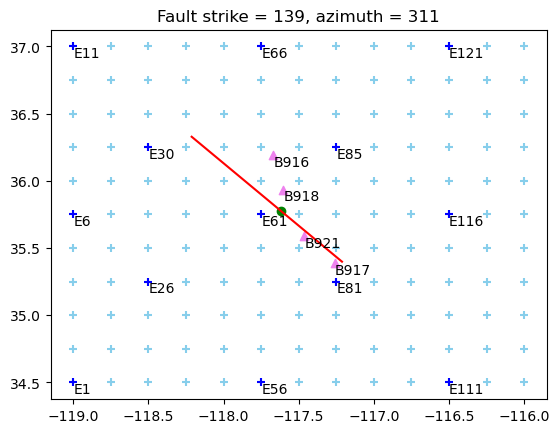

In [26]:
# Pick a few stations

stas_sub = extra_stas.iloc[[0,5,10,25,29,55,60,65,80,84,110,115,120]]
# stas_sub['lon'].values

# Fault extent
min_lon = -118.2123
max_lon = -117.2121
min_lat = 35.3989
max_lat = 36.3284

plt.title('Fault strike = 139, azimuth = 311')
plt.plot([min_lon, max_lon], [max_lat, min_lat], color = 'red', label = 'Planar fault extent')   
plt.scatter(extra_stas['lon'], extra_stas['lat'], marker = '+', color = 'skyblue', label = 'Extra stations')
plt.scatter(stas_sub['lon'], stas_sub['lat'], marker = '+', color = 'blue', label = 'Extra stations sub')
plt.scatter(real_strain_stas_sub['LONG'], real_strain_stas_sub['LAT'], marker = '^', color = 'violet', label = 'Real strain stations')
plt.scatter(hypo_lon, hypo_lat, color = 'green', label = 'Hypocenter')
[plt.text(i, j, f'{name}', va = 'top', ha = 'left') for (i, j, name) in zip(stas_sub['lon'], stas_sub['lat'], stas_sub['name'])];
# [plt.text(i, j, f'{name}', va = 'top', ha = 'left') for (i, j, name) in zip(stas_sub['lon'], stas_sub['lat']-0.1, stas_sub['azimuth'].astype(int))];

[plt.text(i, j, f'{name}', va = 'top', ha = 'left') for (i, j, name) in zip(real_strain_stas_sub['LONG'], real_strain_stas_sub['LAT'], real_strain_stas_sub['BNUM'])];
# [plt.text(i, j, f'{name}', va = 'top', ha = 'left') for (i, j, name) in zip(real_strain_stas_sub['LONG'], real_strain_stas_sub['LAT']-0.1, real_strain_stas_sub['azimuth'].astype(int))];

In [31]:
# Group stations by location/azimuth

fault_az = 311

# Real strain stations

realsta_groups = []
realsta_az_diffs = []

for i in range(len(real_strain_stas_sub)):

    # print(extra_stas['name'].values[i])
    sta_az = real_strain_stas_sub['azimuth'].values[i]
    az_diff = fault_az - sta_az
    # print(int(sta_az), int(az_diff))
    realsta_az_diffs.append(az_diff)
    # print(az_diff)

    if -90 < az_diff <= -45:
        realsta_groups.append('-90--45')
    elif -45 < az_diff <= 0:
        realsta_groups.append('-45-0')
    elif 0 < az_diff <= 45:
        realsta_groups.append('0-45')
    elif 45 < az_diff <= 90:
        realsta_groups.append('45-90')
    elif 90 < az_diff <= 135:
        realsta_groups.append('90-135')
    elif 135 < az_diff <= 180:
        realsta_groups.append('135-180')
    elif 180 < az_diff <= 225:
        realsta_groups.append('180-225')
    elif 225 < az_diff <= 270:
        realsta_groups.append('225-270')
    elif 270 < az_diff <= 315:
        realsta_groups.append('270-315')
    elif 315 < az_diff <= 360:
        realsta_groups.append('315-360')

real_strain_stas_sub['az_group'] = realsta_groups

# Extra grid stations

extra_groups = []
extra_az_diffs = []

for i in range(len(extra_stas)):

    # print(extra_stas['name'].values[i])
    sta_az = extra_stas['azimuth'].values[i]
    az_diff = fault_az - sta_az
    # print(int(sta_az), int(az_diff))
    extra_az_diffs.append(az_diff)
    # print(az_diff)

    if -90 < az_diff <= -45:
        extra_groups.append('-90--45')
    elif -45 < az_diff <= 0:
        extra_groups.append('-45-0')
    elif 0 < az_diff <= 45:
        extra_groups.append('0-45')
    elif 45 < az_diff <= 90:
        extra_groups.append('45-90')
    elif 90 < az_diff <= 135:
        extra_groups.append('90-135')
    elif 135 < az_diff <= 180:
        extra_groups.append('135-180')
    elif 180 < az_diff <= 225:
        extra_groups.append('180-225')
    elif 225 < az_diff <= 270:
        extra_groups.append('225-270')
    elif 270 < az_diff <= 315:
        extra_groups.append('270-315')
    elif 315 < az_diff <= 360:
        extra_groups.append('315-360')

extra_stas['az_group'] = extra_groups

In [33]:
extra_stas
# real_strain_stas_sub

,name,lon,lat,hypo_dist_km,p_arrival,azimuth,az_group
0,E1,-119.0,34.50,189.564786,29.020514,221.931378,45-90
1,E2,-119.0,34.75,169.661378,26.579246,228.105464,45-90
2,E3,-119.0,35.00,152.226967,24.339596,235.802081,45-90
3,E4,-119.0,35.25,138.199839,22.283693,245.265444,45-90
4,E5,-119.0,35.50,128.699697,20.891293,256.479578,45-90
...,...,...,...,...,...,...,...
138,E139,-116.0,36.00,148.374615,23.774972,80.017542,225-270
139,E140,-116.0,36.25,155.166856,24.770485,69.847071,225-270
140,E141,-116.0,36.50,166.365391,26.174974,60.785682,225-270
141,E142,-116.0,36.75,181.155434,27.989059,53.032311,225-270


In [35]:
# Save the arrays with the new hypocentral distance, P-wave arrival time, azimuth, and azimuth group info

extra_stas.to_csv(force_hypo_path + 'force_hypo_extra_stas_w_travel_times_azimuths_azgroups.csv', index = False)
real_strain_stas_sub.to_csv(force_hypo_path + 'force_hypo_real_strain_stas_sub_w_travel_times_azimuths_azgroups.csv', index = False)

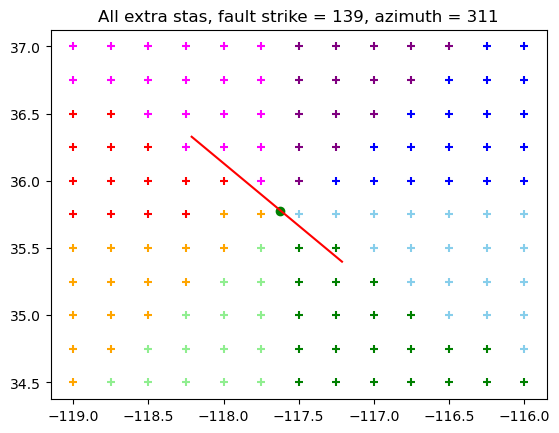

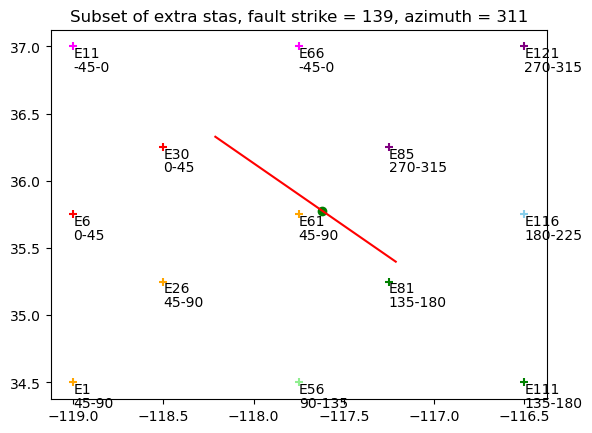

In [37]:
plt.title('All extra stas, fault strike = 139, azimuth = 311')
plt.plot([min_lon, max_lon], [max_lat, min_lat], color = 'red', label = 'Planar fault extent')
plt.scatter(extra_stas['lon'].loc[extra_stas['az_group'] == '-90--45'], extra_stas['lat'].loc[extra_stas['az_group'] == '-90--45'], marker = '+', color = 'pink', label = 'Extra stations')
plt.scatter(extra_stas['lon'].loc[extra_stas['az_group'] == '-45-0'], extra_stas['lat'].loc[extra_stas['az_group'] == '-45-0'], marker = '+', color = 'magenta', label = 'Extra stations')
plt.scatter(extra_stas['lon'].loc[extra_stas['az_group'] == '0-45'], extra_stas['lat'].loc[extra_stas['az_group'] == '0-45'], marker = '+', color = 'red', label = 'Extra stations');
plt.scatter(extra_stas['lon'].loc[extra_stas['az_group'] == '45-90'], extra_stas['lat'].loc[extra_stas['az_group'] == '45-90'], marker = '+', color = 'orange', label = 'Extra stations')
plt.scatter(extra_stas['lon'].loc[extra_stas['az_group'] == '90-135'], extra_stas['lat'].loc[extra_stas['az_group'] == '90-135'], marker = '+', color = 'lightgreen', label = 'Extra stations')
plt.scatter(extra_stas['lon'].loc[extra_stas['az_group'] == '135-180'], extra_stas['lat'].loc[extra_stas['az_group'] == '135-180'], marker = '+', color = 'green', label = 'Extra stations')
plt.scatter(extra_stas['lon'].loc[extra_stas['az_group'] == '180-225'], extra_stas['lat'].loc[extra_stas['az_group'] == '180-225'], marker = '+', color = 'skyblue', label = 'Extra stations')
plt.scatter(extra_stas['lon'].loc[extra_stas['az_group'] == '225-270'], extra_stas['lat'].loc[extra_stas['az_group'] == '225-270'], marker = '+', color = 'blue', label = 'Extra stations')
plt.scatter(extra_stas['lon'].loc[extra_stas['az_group'] == '270-315'], extra_stas['lat'].loc[extra_stas['az_group'] == '270-315'], marker = '+', color = 'purple', label = 'Extra stations')
plt.scatter(extra_stas['lon'].loc[extra_stas['az_group'] == '315-360'], extra_stas['lat'].loc[extra_stas['az_group'] == '315-360'], marker = '+', color = 'black', label = 'Extra stations')
# plt.scatter(stas_sub['lon'], stas_sub['lat'], marker = '+', color = 'black', label = 'Extra stations');
plt.scatter(events['longitude'][0], events['latitude'][0], color = 'green', label = 'Hypocenter');
# [plt.text(i, j, f'{name}', va = 'top', ha = 'left') for (i, j, name) in zip(stas_sub['lon'], stas_sub['lat'], stas_sub['name'])];
plt.show();

stas_sub = extra_stas.iloc[[0,5,10,25,29,55,60,65,80,84,110,115,120]]

plt.title('Subset of extra stas, fault strike = 139, azimuth = 311')
plt.plot([min_lon, max_lon], [max_lat, min_lat], color = 'red', label = 'Planar fault extent') 
plt.scatter(stas_sub['lon'].loc[stas_sub['az_group'] == '-90--45'], stas_sub['lat'].loc[stas_sub['az_group'] == '-90--45'], marker = '+', color = 'pink', label = 'Extra stations')
plt.scatter(stas_sub['lon'].loc[stas_sub['az_group'] == '-45-0'], stas_sub['lat'].loc[stas_sub['az_group'] == '-45-0'], marker = '+', color = 'magenta', label = 'Extra stations')
plt.scatter(stas_sub['lon'].loc[stas_sub['az_group'] == '0-45'], stas_sub['lat'].loc[stas_sub['az_group'] == '0-45'], marker = '+', color = 'red', label = 'Extra stations');
plt.scatter(stas_sub['lon'].loc[stas_sub['az_group'] == '45-90'], stas_sub['lat'].loc[stas_sub['az_group'] == '45-90'], marker = '+', color = 'orange', label = 'Extra stations')
plt.scatter(stas_sub['lon'].loc[stas_sub['az_group'] == '90-135'], stas_sub['lat'].loc[stas_sub['az_group'] == '90-135'], marker = '+', color = 'lightgreen', label = 'Extra stations')
plt.scatter(stas_sub['lon'].loc[stas_sub['az_group'] == '135-180'], stas_sub['lat'].loc[stas_sub['az_group'] == '135-180'], marker = '+', color = 'green', label = 'Extra stations')
plt.scatter(stas_sub['lon'].loc[stas_sub['az_group'] == '180-225'], stas_sub['lat'].loc[stas_sub['az_group'] == '180-225'], marker = '+', color = 'skyblue', label = 'Extra stations')
plt.scatter(stas_sub['lon'].loc[stas_sub['az_group'] == '225-270'], stas_sub['lat'].loc[stas_sub['az_group'] == '225-270'], marker = '+', color = 'blue', label = 'Extra stations')
plt.scatter(stas_sub['lon'].loc[stas_sub['az_group'] == '270-315'], stas_sub['lat'].loc[stas_sub['az_group'] == '270-315'], marker = '+', color = 'purple', label = 'Extra stations')
plt.scatter(stas_sub['lon'].loc[stas_sub['az_group'] == '315-360'], stas_sub['lat'].loc[stas_sub['az_group'] == '315-360'], marker = '+', color = 'black', label = 'Extra stations')
# plt.scatter(stas_sub['lon'], stas_sub['lat'], marker = '+', color = 'black', label = 'Extra stations');
plt.scatter(events['longitude'][0], events['latitude'][0], color = 'green', label = 'Rupture 2 (medium)');
[plt.text(i, j, f'{name}', va = 'top', ha = 'left') for (i, j, name) in zip(stas_sub['lon'], stas_sub['lat'], stas_sub['name'])];
[plt.text(i, j, f'{name}', va = 'top', ha = 'left') for (i, j, name) in zip(stas_sub['lon'], stas_sub['lat']-0.1, stas_sub['az_group'])];
plt.show();

In [48]:
# Make station_plots_w_each_rise_time for homogeneous rupture
        
for i in range(len(stas_sub)):

    sta = stas_sub['name'].values[i]
    theo_p_arr = stas_sub['p_arrival'].values[i]
    hypo_dist = stas_sub['hypo_dist_km'].values[i]
    az_diff = stas_sub['azimuth'].values[i]

    plt.figure(dpi = 300, facecolor = 'white')

    # print(sta)
    # print(theo_p_arr)
    # print(hypo_dist)

    for model in models:

        model_path = results_path + model + '/results/'
        # print(model_path)

        strain_path = model_path + stas_sub['name'].values[i] + 's.txt'
        disp_path = model_path + stas_sub['name'].values[i] + 'd.txt'

        ### Process strain data ###

        time_strain, xx_strain, xy_strain, yy_strain, rms_strain, peak_strain = process_strain(strain_path, theo_p_arr)
        time_gnss, x_gnss, y_gnss, rms_gnss, peak_gnss = process_disp(disp_path, theo_p_arr)

        # Move the flat line at the beginning of each timeseries to the same level

        norm_strain = np.copy(peak_strain)
        norm_level = peak_strain[0]
        norm_strain = norm_strain - norm_level + 1*10**-9 # Subtract the starting value, add 10^-9 to set at 10^0 on nanostrain plot

        if model == 'MH2017':
            rise_time = 2.8
            color = 'orange'
        elif model == 'MH2017-1':
            rise_time = 1.8
            color = 'red'
        elif model == 'MH2017+1':
            rise_time = 3.8
            color = 'green'
        elif model == 'MH2017+2':
            rise_time = 4.8
            color = 'blue'

        plt.title('Homogeneous rupture, station ' + sta + '\nHyp. dist = ' + str(int(hypo_dist)) + 'km, az. diff = ' + str(int(az_diff)) + '$^{\circ}$')
        plt.plot(time_strain, norm_strain, color = color, label = model + ', ' + str(rise_time) + 's rise time')
        plt.axvline(theo_p_arr, color = 'gray', linestyle = '--')
        plt.semilogy()
        plt.xlabel('Time (s)')
        plt.ylabel('Relative peak strain')
        plt.xlim(theo_p_arr-2, theo_p_arr+15)
        plt.legend()

    # plt.show()

    # Create folder for the event
    fig_save_dir = homo_plot_save_path + 'station_plots_w_each_rise_time/'
    # print(fig_save_dir)
    if os.path.isdir(fig_save_dir):
        pass
    else:
        os.makedirs(fig_save_dir)
    plt.savefig(fig_save_dir + sta + '.png', format = 'PNG')
    plt.close()


In [53]:
# Make mean lines for station_plots_by_azimuth_difference for homogeneous rupture

for model in models:
    
    print(model)

    pink = extra_stas.loc[lambda extra_stas: extra_stas['az_group'] == '-90--45'].index.values
    magenta = extra_stas.loc[lambda extra_stas: extra_stas['az_group'] == '-45-0'].index.values
    red = extra_stas.loc[lambda extra_stas: extra_stas['az_group'] == '0-45'].index.values
    orange = extra_stas.loc[lambda extra_stas: extra_stas['az_group'] == '45-90'].index.values
    lightgreen = extra_stas.loc[lambda extra_stas: extra_stas['az_group'] == '90-135'].index.values
    green = extra_stas.loc[lambda extra_stas: extra_stas['az_group'] == '135-180'].index.values
    skyblue = extra_stas.loc[lambda extra_stas: extra_stas['az_group'] == '180-225'].index.values
    blue = extra_stas.loc[lambda extra_stas: extra_stas['az_group'] == '225-270'].index.values
    purple = extra_stas.loc[lambda extra_stas: extra_stas['az_group'] == '270-315'].index.values
    black = extra_stas.loc[lambda extra_stas: extra_stas['az_group'] == '315-360'].index.values

    color_groups = [pink, magenta, red, orange, lightgreen, green, skyblue, blue, purple, black]
    num_groups = len(color_groups)
    counter = 0

    # Initialize array to store mean strain data for each group
    mean_time_strain = np.zeros((num_groups, 163))
    mean_peak_strain = np.zeros((num_groups, 163))
    std_peak_strain = np.zeros((num_groups, 163))

    for c in range(len(color_groups)):

        group_of_indices = color_groups[c]

        counter += 1
        # print('Group #' + str(counter))
        # print(str(len(group_of_indices)) + ' stations')

        if len(group_of_indices) > 0:

            # Initiate arrays of data
            theo_p_arrs_group = np.zeros((len(group_of_indices),))
            time_strain_group = np.zeros((len(group_of_indices), 1148))
            peak_strain_group = np.zeros((len(group_of_indices), 1148))
            peak_gnss_group = np.zeros((len(group_of_indices), 1148))
            trimmed_time_strain_group = np.zeros((len(group_of_indices), 163))
            trimmed_peak_strain_group = np.zeros((len(group_of_indices), 163))

            for i in range(len(group_of_indices)):

                index = group_of_indices[i]
                # print(index)

                model_path = results_path + model + '/results/'
                # print(model_path)
                sta = extra_stas['name'].values[index]
                theo_p_arr = extra_stas['p_arrival'].values[index]
                # print(sta)
                # print(theo_p_arr)

                strain_path = model_path + extra_stas['name'].values[index] + 's.txt'
                disp_path = model_path + extra_stas['name'].values[index] + 'd.txt'

                ### Process strain data ###

                time_strain, xx_strain, xy_strain, yy_strain, rms_strain, peak_strain = process_strain(strain_path, theo_p_arr)
                time_gnss, x_gnss, y_gnss, rms_gnss, peak_gnss = process_disp(disp_path, theo_p_arr)

                strain_samp_rate = len(time_strain) / time_strain[-1]
                gnss_samp_rate = len(time_gnss / time_gnss[-1])
                strain_dt = 1/strain_samp_rate

                # Move the flat line at the beginning of each timeseries to the same level

                norm_strain = np.copy(peak_strain)
                norm_level = peak_strain[0]
                norm_strain = norm_strain - norm_level + 1*10**-9 # Subtract the starting value, add 10^-9 to set at 10^0 on nanostrain plot

                # Shift so that the P-wave is aligned for each trace at 10 seconds into waveform

                if theo_p_arr >= 10: # Shift the strain backward
                    shift_amount = theo_p_arr - 10
                    time_strain = time_strain - shift_amount
                else: # Shift the strain forward
                    shift_amount = 10 - theo_p_arr
                    time_strain = time_strain + shift_amount

                # Add to arrays
                theo_p_arrs_group[i,] = theo_p_arr
                time_strain_group[i,:] = time_strain
                peak_strain_group[i,:] = norm_strain
                # peak_gnss_group[i,:] = norm_gnss 

            # Cut to size

            new_p_time = 10
            start_time = 8
            end_time = 25
            time_before_p = new_p_time - start_time
            time_after_p = end_time - new_p_time

            new_time_strain = np.arange(start_time, end_time, strain_dt)

            for j in range(len(peak_strain_group)):

                trimmed_time_strain_group[j,:] = new_time_strain

                theo_p_arr = theo_p_arrs_group[j]
                # print(theo_p_arr)
                new_peak_strain = peak_strain_group[j][int((theo_p_arr-time_before_p)*strain_samp_rate):int((theo_p_arr+time_after_p)*strain_samp_rate)]
                # print(new_time_strain.shape, new_peak_strain.shape)
                if new_time_strain.shape[0] != new_peak_strain.shape[0]:
                    diff = new_time_strain.shape[0] - new_peak_strain.shape[0]
                    # print(diff)
                    if diff > 0:
                        new_peak_strain = peak_strain_group[j][int((theo_p_arr-time_before_p)*strain_samp_rate):int((theo_p_arr+time_after_p)*strain_samp_rate)+diff]
                    elif diff < 0:
                        new_peak_strain = peak_strain_group[j][int((theo_p_arr-time_before_p)*strain_samp_rate):int((theo_p_arr+time_after_p)*strain_samp_rate)-diff]
                # print(new_time_strain.shape, new_peak_strain.shape)

                trimmed_peak_strain_group[j,:] = new_peak_strain

            # Get the mean of the strain for each group

            group_mean_time = trimmed_time_strain_group[0]
            group_mean_strain = np.mean(trimmed_peak_strain_group, axis = 0)
            group_std_strain = np.std(trimmed_peak_strain_group, axis = 0)

            # Plot

            plt.title(model + '_group_' + str(counter))
            for l in range(len(trimmed_peak_strain_group)):
                plt.plot(trimmed_time_strain_group[l], trimmed_peak_strain_group[l])
            plt.plot(group_mean_time, group_mean_strain, color = 'red', linestyle = '--', lw = 5, label = 'Group mean')
            # plt.plot(group_mean_time, group_mean_strain + group_std_strain, color = 'turquoise', linestyle = '--', lw = 2)
            # plt.plot(group_mean_time, group_mean_strain - group_std_strain, color = 'turquoise', linestyle = '--', lw = 2)
            plt.semilogy()
            # plt.show()

            # Create folder for the event
            save_dir = homo_plot_save_path + 'az_group_mean_peak_strain_npys_figs/' + str(model) + '/'
            # print(fig_save_dir)
            if os.path.isdir(save_dir):
                pass
            else:
                os.makedirs(save_dir)

            plt.savefig(save_dir + 'group_' + str(counter) + '.png', format = 'PNG')
            plt.close()

           # Store mean strain data for each group

            mean_time_strain[c,:] = group_mean_time
            mean_peak_strain[c,:] = group_mean_strain  
            std_peak_strain[c,:] = group_std_strain 

    # Save npys

    np.save(save_dir + 'mean_time_strain.npy', mean_time_strain)
    np.save(save_dir + 'mean_peak_strain.npy', mean_peak_strain)
    np.save(save_dir + 'std_peak_strain.npy', std_peak_strain)


MH2017
MH2017+1
MH2017+2
MH2017-1


In [61]:
# Make station_plots_by_azimuth_difference for homogeneous rupture

for model in models: # :1 is the MH2017 model only
    
    model_path = results_path + model + '/results/'
    # print(model_path)

    plt.figure(dpi = 300, figsize = (8,4.5), facecolor = 'white')
    plt.title(model)
    
    highylim = 0

    for i in range(len(extra_stas)):
        
        sta = extra_stas['name'].values[i]
        theo_p_arr = extra_stas['p_arrival'].values[i]
        hypo_dist = extra_stas['hypo_dist_km'].values[i]
        az_diff = extra_stas['azimuth'].values[i]

        # plt.figure(dpi = 100, facecolor = 'white')

        # print(sta)
        # print(theo_p_arr)
        # print(hypo_dist)

        strain_path = model_path + extra_stas['name'].values[i] + 's.txt'
        disp_path = model_path + extra_stas['name'].values[i] + 'd.txt'

        ### Process strain data ###

        time_strain, xx_strain, xy_strain, yy_strain, rms_strain, peak_strain = process_strain(strain_path, theo_p_arr)
        time_gnss, x_gnss, y_gnss, rms_gnss, peak_gnss = process_disp(disp_path, theo_p_arr)

        # print(peak_strain.shape)
        # print(peak_gnss.shape)

        # Move the flat line at the beginning of each timeseries to the same level

        norm_strain = np.copy(peak_strain)
        norm_level = peak_strain[0]
        norm_strain = norm_strain - norm_level + 1*10**-9 # Subtract the starting value, add 10^-9 to set at 10^0 on nanostrain plot

        # Color by azimuth group
        az_group = extra_stas['az_group'].values[i]
        # print(az_group)

        if az_group == '-90--45':
            color = 'pink'
        elif az_group == '-45-0':
            color = 'magenta'
        elif az_group == '0-45':
            color = 'red'
        elif az_group == '45-90':
            color = 'orange'
        elif az_group == '90-135':
            color = 'lightgreen'
        elif az_group == '135-180':
            color = 'green'
        elif az_group == '180-225':
            color = 'skyblue'
        elif az_group == '225-270':
            color = 'blue'
        elif az_group == '270-315':
            color = 'purple'
        elif az_group == '315-360':
            color = 'black'

        # print(color)

        # Shift so that the P-wave is aligned for each trace at 10 seconds into waveform

        if theo_p_arr >= 10: # Shift the strain backward
            shift_amount = theo_p_arr - 10
            time_strain = time_strain - shift_amount
        else: # Shift the strain forward
            shift_amount = 10 - theo_p_arr
            time_strain = time_strain + shift_amount

        # Make a plot for each station

        plot_peak = True  # Plot peak strain or RMS strain?
        tol = 0.1 # Tolerance for finding matching samples with time for plot limits
        
        # print(highylim)

        if plot_peak:
            plt.plot(time_strain, norm_strain, color = color, linestyle = 'solid', alpha = 0.1)
            lowxlim = 8
            highxlim = 25
            lowx_samp = np.where(np.abs(time_strain-lowxlim) < tol)[0][0]
            highx_samp = np.where(np.abs(time_strain-highxlim) < tol)[0][0]
            lowylim = 7*10**-10
            new_highylim = max(norm_strain[lowx_samp:highx_samp]) * 2
            if new_highylim > highylim:
                highylim = new_highylim
            plt.semilogy()

        else:
            plt.plot(time_strain, rms_strain, color = color, linestyle = 'solid', alpha = 0.1)
            lowxlim = 8
            highxlim = 12
            lowx_samp = np.where(np.abs(time_strain-lowxlim) < tol)[0][-1]
            highx_samp = np.where(np.abs(time_strain-highxlim) < tol)[0][-1]
            lowylim = 0
            new_highylim = max(rms_strain[lowx_samp:highx_samp+1])
            if new_highylim > highylim:
                highylim = new_highylim

        highylim = 10**-4
        # print(highylim)
        plt.xlim(lowxlim, highxlim)
        plt.ylim(lowylim, highylim)
        plt.xlabel('Time (s)')
        plt.ylabel('Relative peak strain')

    # Load the group mean info
    mean_dir = homo_plot_save_path + 'az_group_mean_peak_strain_npys_figs/' + str(model) + '/'
    mean_time_strain = np.load(mean_dir + 'mean_time_strain.npy')
    mean_peak_strain = np.load(mean_dir + 'mean_peak_strain.npy')

    plot_colors = ['pink', 'magenta', 'red', 'orange', 'lightgreen', 'green', 'skyblue', 'blue', 'purple', 'black']
    az_labels = ['-90--45', '-45-0', '0-45', '45-90', '90-135', '135-180', '180-225', '225-270', '270-315', '315-360']

    for g in range(len(mean_time_strain)):
        time = mean_time_strain[g]
        strain = mean_peak_strain[g]
        plt.plot(time, strain, color = plot_colors[g], label = az_labels[g])
    # plt.xlim(mean_time_strain[1,0], mean_time_strain[1,-1])
    # plt.semilogy()

    plt.axvline(10, color = 'gray', linestyle = 'dashed', lw = 1, alpha = 0.7, label = 'P-wave arrival')

    plt.legend(loc = 'center right', bbox_to_anchor = (0.9, 0.5, 0.5, 0))   

    plt.subplots_adjust(right = 0.7)

    # plt.show()

    # Create folder for the event
    fig_save_dir = homo_plot_save_path + 'station_plots_by_az_diff/'
    # print(fig_save_dir)
    if os.path.isdir(fig_save_dir):
        pass
    else:
        os.makedirs(fig_save_dir)
    plt.savefig(fig_save_dir + model + '.png', format = 'PNG')
    plt.close()


In [62]:
# Look at the results from Dara's model compared to the homogeneous real strain locations

dara_p_arrivals = pd.read_csv('/Users/sydneydybing/SW4/strain/sw4_strain_stations_metadata.csv').query('BNUM in @rc_stas_sub').reset_index(drop = True)
dara_p_arrivals

,BNUM,NAME,LAT,LONG,ELEV(m),INSTALL_DATE,CH0(EofN),BSM_Depth(m),SEISMOMETER_Depth(m),PORE_DEPTH(m),...,DATA_END,GAP(m),L_DATE,L0(cnts),L1(cnts),L2(cnts),L3(cnts),REGION,hypo_dist_km,p_arrival
0,B916,marips916bcs2008,36.1925,-117.6685,1859.9,3/13/08,303.6,176.5,166.9,NaN,...,Present,0.0001,2008:090,55948375,53191200,55522127,49391430,Mojave_California,47.348199,8.224188
1,B917,tonyso917bcs2008,35.3892,-117.2587,1125.9,7/14/08,306.1,162.5,Unknown,NaN,...,Present,0.0001,2008:219,51200216,53318503,50164819,49964400,Mojave_California,52.284362,9.024224
2,B918,mtsprn918bcs2008,35.9357,-117.6017,1042.6,6/21/08,288.9,196.7,189.9,NaN,...,Present,0.0001,2008:245,56324863,55262353,53608304,55388642,Mojave_California,18.442171,3.584549
3,B921,randsb921bcs2008,35.5865,-117.4622,694.5,6/3/08,340.5,147.4,139.9,NaN,...,Present,0.0001,2008:178,53324139,53302937,55141972,53475662,Mojave_California,23.798922,4.428801


In [68]:
# Make dara_model_vs_homo_models
   
for i in range(len(real_strain_stas_sub)):

    sta = real_strain_stas_sub['BNUM'].values[i]
    
    print(sta)
    # print(theo_p_arr)
    # print(dara_theo_p_arr)
    # print(hypo_dist)

    # Load and process data from Dara's rupture model

    dara_strain = np.load('/Users/sydneydybing/SW4/strain/rms_and_peak_sw4_data/strain/peak/' + real_strain_stas_sub['BNUM'].values[i] + '.npy')
    # print(dara_strain)
    dara_time_strain = dara_strain[:,0]
    dara_peak_strain = dara_strain[:,1]
    
    # Move the flat line at the beginning of each timeseries to the same level

    dara_norm_strain = np.copy(dara_peak_strain)
    dara_norm_level = dara_peak_strain[0]
    dara_norm_strain = dara_norm_strain - dara_norm_level + 1*10**-9 # Subtract the starting value, add 10^-9 to set at 10^0 on nanostrain plot

    dara_theo_p_arr = dara_p_arrivals['p_arrival'].values[i]
        
    theo_p_arr = real_strain_stas_sub['p_arrival'].values[i]
    hypo_dist = real_strain_stas_sub['hypo_dist_km'].values[i]
    az = real_strain_stas_sub['azimuth'].values[i]
    az_diff = fault_az - az

    plt.figure(dpi = 300, facecolor = 'white')

    for model in models:

        model_path = results_path + model + '/results/'
        # print(model_path)

        strain_path = model_path + real_strain_stas_sub['BNUM'].values[i] + 's.txt'
        disp_path = model_path + real_strain_stas_sub['BNUM'].values[i] + 'd.txt'

        ### Process strain data ###

        time_strain, xx_strain, xy_strain, yy_strain, rms_strain, peak_strain = process_strain(strain_path, theo_p_arr)
        time_gnss, x_gnss, y_gnss, rms_gnss, peak_gnss = process_disp(disp_path, theo_p_arr)

        # Move the flat line at the beginning of each timeseries to the same level

        norm_strain = np.copy(peak_strain)
        norm_level = peak_strain[0]
        norm_strain = norm_strain - norm_level + 1*10**-9 # Subtract the starting value, add 10^-9 to set at 10^0 on nanostrain plot

        if model == 'MH2017':
            rise_time = 2.8
            color = 'orange'
        elif model == 'MH2017-1':
            rise_time = 1.8
            color = 'red'
        elif model == 'MH2017+1':
            rise_time = 3.8
            color = 'green'
        elif model == 'MH2017+2':
            rise_time = 4.8
            color = 'blue'

        # Shift to align P-arrivals

        if theo_p_arr >= dara_theo_p_arr: # Shift the strain backward
            shift_amount = theo_p_arr - dara_theo_p_arr
            time_strain = time_strain - shift_amount
        else: # Shift the strain forward
            shift_amount = dara_theo_p_arr - theo_p_arr
            time_strain = time_strain + shift_amount

        # Plot

        plt.title("Homogeneous rupture vs. Dara's model, station " + sta + "\nHyp. dist = " + str(int(hypo_dist)) + "km, az. diff = " + str(int(az_diff)) + "$^{\circ}$")
        plt.plot(time_strain, norm_strain, color = color, label = 'Homogenous model:\n' + str(rise_time) + 's rise time')
        # plt.axvline(theo_p_arr, color = 'gray', linestyle = '--')

    plt.plot(dara_time_strain, dara_norm_strain, color = 'black', label = "Dara's model")
    plt.axvline(dara_theo_p_arr, color = 'gray', linestyle = '--', label = 'P-wave arrival') 
    plt.xlabel('Time (s)')
    plt.ylabel('Relative peak strain')
    plt.xlim(dara_theo_p_arr-2, dara_theo_p_arr+15)
    plt.semilogy()
    plt.legend()

    # plt.show()

    # Create folder for the event
    fig_save_dir = homo_plot_save_path + 'dara_model_vs_homo_models/'
    # print(fig_save_dir)
    if os.path.isdir(fig_save_dir):
        pass
    else:
        os.makedirs(fig_save_dir)
    plt.savefig(fig_save_dir + sta + '.png', format = 'PNG')
    plt.close()


B916
B917
B918
B921


In [41]:
### Process strain data ###

def process_strain(strain_data, theoretical_p_arrival):
    
    strain = pd.read_csv(strain_path, sep = '\s+', skiprows = 16, names = ['time', 'xx', 'yy', 'zz', 'xy', 'xz', 'yz'])

    # Calculate horizontal RMS strain
    time_strain = strain.time.values
    xx_strain = strain.xx.values
    xy_strain = strain.xy.values
    yy_strain = strain.yy.values
    rms_strain = np.sqrt((xx_strain**2 + xy_strain**2 + yy_strain**2)/3)

    # Calculate peak strain
    strain_p_i = np.abs(time_strain - theo_p_arr).argmin() # Get the index where the P-wave arrives
    mod_rms_strain = rms_strain.copy()
    p_arr_strain = rms_strain[strain_p_i]
    mod_rms_strain[:strain_p_i] = p_arr_strain # Strain before the P wave is set to be the same as the strain AT the P wave
    peak_strain = mod_rms_strain.copy()
    for k in range(0,len(mod_rms_strain)):
        if k == 0:
            strain = mod_rms_strain[0]
            max_strain = strain
        else:
            # Grab progressively longer windows and save the biggest strain
            strain = mod_rms_strain[:k+1] # Has to be k+1 because slicing doesn't include last one
            max_strain = max(strain)
        # Put peak strain back into the output stream
        peak_strain[k] = max_strain 
    
    return time_strain, xx_strain, xy_strain, yy_strain, rms_strain, peak_strain

### Process GNSS data to match the strain processing ###

def process_disp(disp_data, theoretical_p_arrival):
    
    disp = pd.read_csv(disp_path, sep = '\s+', skiprows = 13, names = ['time', 'x', 'y', 'z'])

    # Calculate horizontal RMS GNSS  
    time_gnss = disp.time.values
    x_gnss = disp.x.values
    y_gnss = disp.y.values
    rms_gnss = np.sqrt((x_gnss**2 + y_gnss**2)/2)

    # Calculate peak GNSS
    gnss_p_i = np.abs(time_gnss - theo_p_arr).argmin() # Get the index where the P-wave arrives
    mod_rms_gnss = rms_gnss.copy()
    p_arr_gnss = rms_gnss[gnss_p_i]
    mod_rms_gnss[:gnss_p_i] = p_arr_gnss # Strain before the P wave is set to be the same as the strain AT the P wave
    peak_gnss = mod_rms_gnss.copy()
    for k in range(0,len(mod_rms_gnss)):
        if k == 0:
            gnss = mod_rms_gnss[0]
            max_gnss = gnss
        else:
            # Grab progressively longer windows and save the biggest strain
            gnss = mod_rms_gnss[:k+1] # Has to be k+1 because slicing doesn't include last one
            max_gnss = max(gnss)
        # Put peak strain back into the output stream
        peak_gnss[k] = max_gnss 
    
    return time_gnss, x_gnss, y_gnss, rms_gnss, peak_gnss